In [1]:
# data paths Hermen
# data_path_training_images = r"C:\Users\herme\Documents\Werk\PhD - UT - Sound Check\Courses\Deep learning for 3D medical image analysis\Project\training\images"
# data_path_training_masks = r"C:\Users\herme\Documents\Werk\PhD - UT - Sound Check\Courses\Deep learning for 3D medical image analysis\Project\training\mask"
# data_path_training_segmentations = r"C:\Users\herme\Documents\Werk\PhD - UT - Sound Check\Courses\Deep learning for 3D medical image analysis\Project\training\1st_manual"
# data_path_secret_test = r"C:\Users\herme\Documents\Werk\PhD - UT - Sound Check\Courses\Deep learning for 3D medical image analysis\Project\drive_secret"

# data paths Lobke
data_path_training_images = 'training/images'
data_path_training_masks = 'training/mask'
data_path_training_segmentations = 'training/1st_manual'
data_path_secret_test = 'secret_test'


# check if data_path exists:
import os

if not os.path.exists(data_path_training_images):
    print("Please update your images data path to an existing folder.")
else:
    print("Congrats! You selected the correct training images folder :)")

if not os.path.exists(data_path_training_masks):
    print("Please update your masks data path to an existing folder.")
else:
    print("Congrats! You selected the correct training masks folder :)")

if not os.path.exists(data_path_training_segmentations):
    print("Please update your segmentations data path to an existing folder.")
else:
    print("Congrats! You selected the correct training segmentations folder :)")
    
if not os.path.exists(data_path_secret_test):
    print("Please update your secret test set data path to an existing folder.")
else:
    print("Congrats! You selected the correct secret test set folder :)")


Congrats! You selected the correct training images folder :)
Congrats! You selected the correct training masks folder :)
Congrats! You selected the correct training segmentations folder :)
Congrats! You selected the correct secret test set folder :)


In [2]:
# import packages
import glob
import torch
import numpy as np
import monai
from monai.networks.nets import UNet
from monai.transforms import Compose, LoadImaged, ScaleIntensityd, ToTensord, RandFlipd, RandSpatialCropSamplesd, EnsureChannelFirstd, Lambdad, Transposed
from monai.data import DataLoader, CacheDataset, ITKWriter
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from monai.transforms import Transform
from monai.transforms import Compose, Lambda, AsDiscrete

In [3]:
# settings for important parameters

# data parameters
num_test_files = 2
num_validation_files = 2
num_train_files = 20 - num_test_files - num_validation_files
roi_size = (160)          # region of interest size
trans_prob = 0.5        # transform probability
batch_size = 2

# model parameters
num_epochs = 200 # train for at least 4000 epochs, but no clear overfitting at 10000 epochs
validation_wait = 10

In [4]:
# set random seeds
Seed = 2071293819 # 01111011011101010110111101111011 in binary
monai.utils.set_determinism(seed=Seed) # set seed for model reproducibility

# Set seed for PyTorch
torch.manual_seed(Seed)
torch.cuda.manual_seed(Seed)

# Ensure deterministic behavior pytorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# Load Dataset Paths
image_files = sorted(glob.glob(os.path.join(data_path_training_images, '*.tif')))
mask_files = sorted(glob.glob(os.path.join(data_path_training_masks, '*.gif')))
segmentation_files = sorted(glob.glob(os.path.join(data_path_training_segmentations, '*.gif')))

# Split the dataset into training, validation and test sets
train_files = [{"img": img, "seg": seg} for img, seg in zip(image_files[0:num_train_files], segmentation_files[0:num_train_files])]
validation_files = [{"img": img, "seg": seg} for img, seg in zip(image_files[num_train_files:num_train_files+num_validation_files], segmentation_files[num_train_files:num_train_files+num_validation_files])]
test_files = [{"img": img, "seg": seg} for img, seg in zip(image_files[num_train_files+num_validation_files:], segmentation_files[num_train_files+num_validation_files:])]

def rgb_to_grayscale(img):
    return img[..., 1]  # No need to add a channel dimension here

def visualize_sample(sample, title1=None, title2=None):
    # Visualize the x-ray and overlay the mask, using the dictionary as input
    image = np.squeeze(sample['img'][0,0,:,:])
    mask = np.squeeze(sample['seg'][0,0,:,:])
    fig = plt.figure(figsize=[10,7])
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(image, 'gray')
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(image, 'gray')
    overlay_mask = np.ma.masked_where(mask == 0, mask == 1)
    ax2.imshow(overlay_mask, 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')
    if title1 is not None:
        ax1.set_title(title1)
    if title2 is not None:
        ax2.set_title(title2)
    plt.show()
    
class ThresholdTransform(Transform): # sets pixels less than a specified threshold to zero.
    def __init__(self, keys, threshold):
        self.keys = keys
        self.threshold = threshold
    def __call__(self, data):
        for key in self.keys:
            img = data[key]
            img[img < self.threshold] = 0
            data[key] = img
        return data

# Define Transformation
train_transform = Compose([
    LoadImaged(keys=["img", "seg"], reader='monai.data.ITKReader'),
    EnsureChannelFirstd(keys=["img", "seg"], channel_dim='no_channel'),
    ScaleIntensityd(keys=["img", 'seg']),
    ThresholdTransform(keys=["img"], threshold=0.07),
    ToTensord(keys=["img", "seg"]), 
    Lambdad(keys=["img"], func=lambda x: rgb_to_grayscale(x)),
    RandFlipd(keys=["img", "seg"], prob=trans_prob, spatial_axis=1),
    RandSpatialCropSamplesd(keys=["img", "seg"], roi_size=[roi_size, roi_size], num_samples=1, random_size=False),
])

validation_test_transform = Compose([
    LoadImaged(keys=["img", "seg"], reader='monai.data.ITKReader'),
    EnsureChannelFirstd(keys=["img", "seg"], channel_dim='no_channel'),
    ScaleIntensityd(keys=["img", "seg"]),
    ThresholdTransform(keys=["img"], threshold=0.07),
    ToTensord(keys=["img", "seg"]),
    Lambdad(keys=["img"], func=lambda x: rgb_to_grayscale(x)),
])

# Create CacheDataset
train_data = CacheDataset(data=train_files, transform=train_transform)
validation_data = CacheDataset(data=validation_files, transform=validation_test_transform)
test_data = CacheDataset(data=test_files, transform=validation_test_transform)

# Create DataLoader
train_loader = DataLoader(train_data, num_workers=0, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, num_workers=0, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, num_workers=0, batch_size=batch_size, shuffle=True)


Loading dataset: 100%|██████████| 2/2 [00:00<00:00, 32.34it/s]


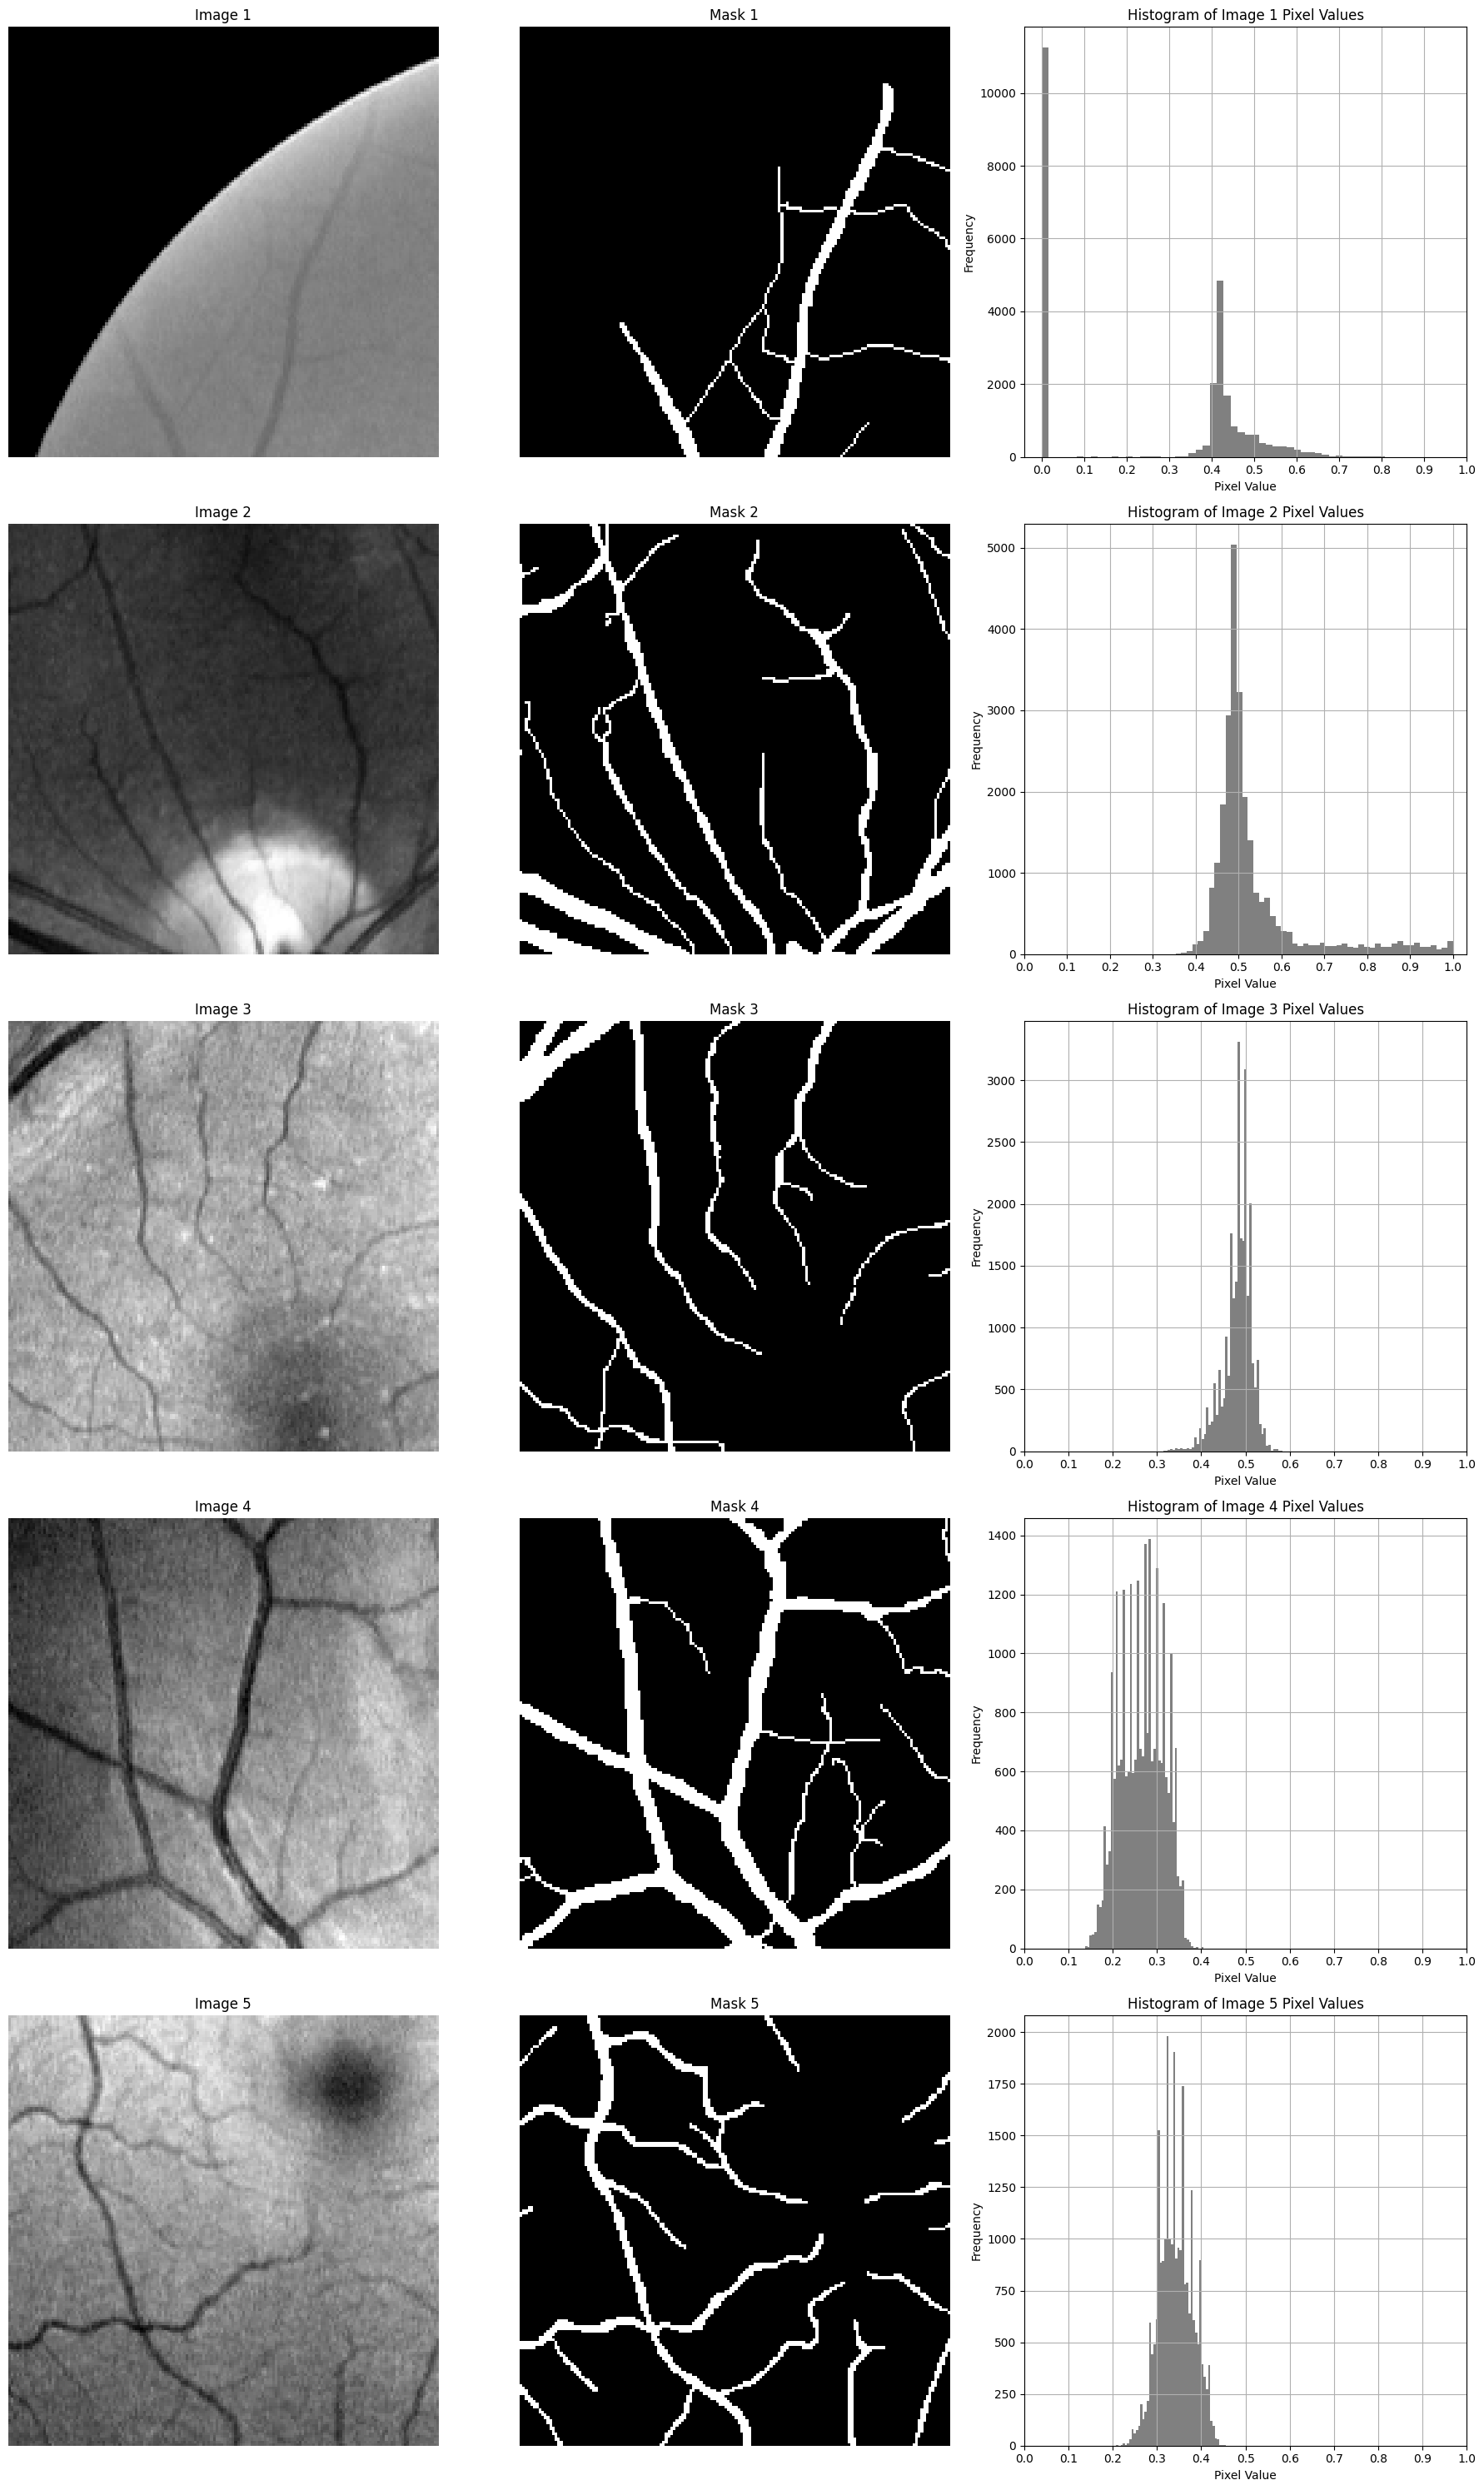

In [6]:
# added to visualize the data after pre-poscessing (after transformations)

def visualize_five_samples_across_batches(data_loader):
    # Prepare a figure to accommodate 5 images and their histograms
    fig, axs = plt.subplots(5, 3, figsize=(18, 30))  # 5 rows (for each image), 3 columns (for image, mask, histogram)
    
    image_count = 0  # Track the number of images processed

    # Iterate over batches until we have displayed 5 images
    for batch in data_loader:
        for i in range(batch['img'].shape[0]):
            if image_count >= 5:
                break  # Stop if we have already processed 5 images

            # Extract image and mask
            image = batch['img'][i]
            mask = batch['seg'][i]

            # Convert to numpy arrays
            image_np = image.numpy().squeeze()
            mask_np = mask.numpy().squeeze()

            # Display the image
            axs[image_count, 0].imshow(image_np, cmap='gray')
            axs[image_count, 0].set_title(f'Image {image_count+1}')
            axs[image_count, 0].axis('off')

            # Display the mask
            axs[image_count, 1].imshow(mask_np, cmap='gray')
            axs[image_count, 1].set_title(f'Mask {image_count+1}')
            axs[image_count, 1].axis('off')

            # Display histogram of pixel values in the image
            axs[image_count, 2].hist(image_np.flatten(), bins=50, color='gray')
            axs[image_count, 2].set_title(f'Histogram of Image {image_count+1} Pixel Values')
            axs[image_count, 2].set_xlabel('Pixel Value')
            axs[image_count, 2].set_ylabel('Frequency')
            axs[image_count, 2].set_xticks(np.arange(0, 1.1, 0.1))
            axs[image_count, 2].grid(True)  # Add a grid to the histogram plot

            image_count += 1  # Increment the count of images processed

        if image_count >= 5:
            break  # Exit the outer loop if 5 images have been processed

    plt.tight_layout()
    plt.show()

# Example usage
visualize_five_samples_across_batches(train_loader)


In [7]:
from IPython.display import display, clear_output

# Model
model = UNet(
    spatial_dims=2,           #input data is 2D
    in_channels=1,            #input image has 1 channel (if RGB it would be 3)
    out_channels=1,           # binairy segmentation, each pixel is one of 2 things
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),     # strides = how much spatial dimention is reduced
    dropout=0,
    # strides=(1, 1, 1, 1),
    # num_res_units=2
)

# Loss and optimizer
# loss_function = monai.losses.SoftDiceclDiceLoss(iter_ = 25, alpha = 0.3, smooth=1e-6) # YES! Note: iter should be equal or greater than largest observed vessel radius; alpha is ratio of centerline loss (regular dice loss is weighted as 1-alpha); smooth is smoothing factor for dice loss to prevent divergence if dice would divide by zero
# loss_function = monai.losses.SoftclDiceLoss(iter_=25, smooth=1e-6)
loss_function =  monai.losses.DiceLoss(sigmoid=True, batch=True, include_background=False) # YES!
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

inferer = monai.inferers.SlidingWindowInferer(roi_size=[roi_size, roi_size], overlap=0.5)
discrete_transform = monai.transforms.AsDiscrete(logit_thresh=0.5, threshold_values=True)     #converts logits to discrete binary values (0 or 1), with a threshold of 0.5
Sigmoid = torch.nn.Sigmoid()

# Training loop
model_loss = np.zeros(num_epochs)
validation_loss = np.zeros(num_epochs)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
epoch = 0
with tqdm(range(num_epochs), unit="epochs") as tqdm_iterator:
    tqdm_iterator.set_description('Training{}'.format(''))

    for i, epoch in enumerate(tqdm_iterator):
        model.train()
        training_steps=0
        epoch_loss = 0
        for batch_data in train_loader:
            training_steps+=1
            inputs, segmentations = batch_data['img'].to(device), batch_data['seg'].to(device)
            # print(inputs.shape, segmentations.shape)
            optimizer.zero_grad()
            outputs = model(inputs)
            # loss = loss_function(outputs, segmentations)
            # print(type(outputs))
            # print(type(segmentations))
            # print(outputs.shape, segmentations.shape)
            # print(segmentations is None)
            loss = loss_function(outputs, segmentations)
            # loss = loss_function(segmentations, outputs)

            # loss1 = loss_function1(segmentations, outputs)
            # print(loss.item(),loss1.item())
            print(loss.item())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        model_loss[epoch] = epoch_loss/training_steps
        print(epoch_loss/training_steps)
        # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {model_loss[epoch]:.4f}')
        if (epoch+1) % validation_wait == 0:
            model.eval()
            validation_steps=0
            validation_epoch_loss = 0
            for batch_data in validation_loader:
                validation_steps+=1
                inputs, segmentations = batch_data['img'].to(device), batch_data['seg'].to(device)
                print(inputs.shape, segmentations.shape)
                
                with torch.no_grad():
                    # outputs = discrete_transform(Sigmoid(inferer(inputs.to(device), network=model)))#.squeeze()
                    outputs = inferer(inputs.to(device), network=model)
                    dict_outputs = {'output': outputs}  # Wrap the tensor into a dictionary
                    processed_outputs = post_prediction_transform(dict_outputs)['output']

                # outputs = model(inputs)
                print(outputs.shape, segmentations.shape)
                loss = loss_function(outputs, segmentations)
                # loss = loss_function(segmentations, outputs)
                validation_epoch_loss += loss.item()
            validation_loss[(epoch-validation_wait+1):epoch+1] = validation_epoch_loss/validation_steps*np.ones(validation_wait)
            
            clear_output(wait=True)
            display(f'Epoch {epoch+1}/{num_epochs}, Loss: {model_loss[epoch]:.4f}, Validation loss: {validation_loss[epoch]:.4f}')

'Epoch 200/200, Loss: 0.2448, Validation loss: 0.2354'

Training: 100%|██████████| 200/200 [00:39<00:00,  5.10epochs/s]


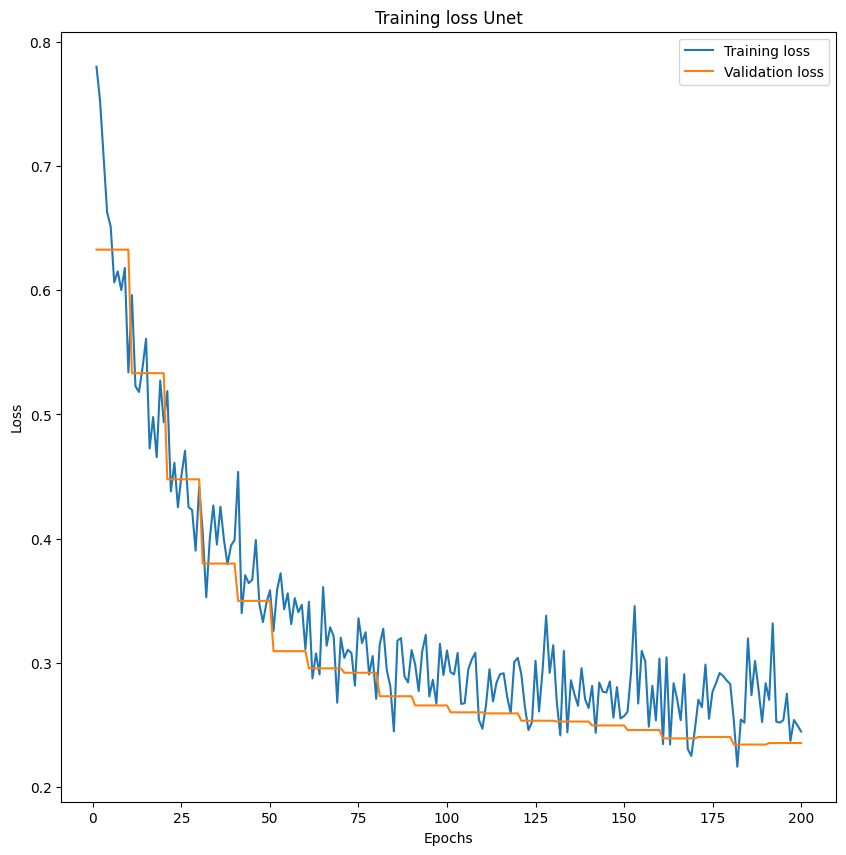

In [10]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(np.arange(1,num_epochs+1), model_loss)
ax1.plot(np.arange(1,num_epochs+1), validation_loss)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training loss Unet')
ax1.legend(['Training loss', 'Validation loss'])
plt.show()

Loss is 0.2484397292137146
Loss is 0.24843966960906982
Mean Dice score is 0.7602524757385254


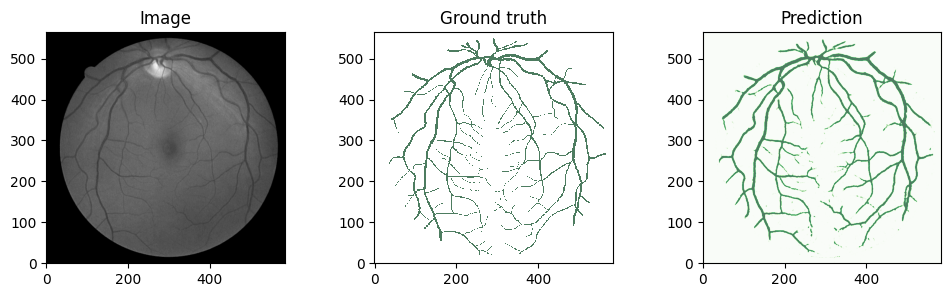

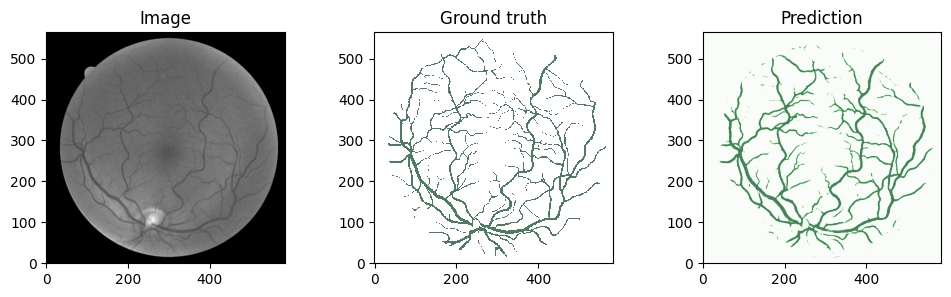

In [25]:
def visual_evaluation(sample, model):
    model.eval()
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[roi_size, roi_size], overlap=0.5)
    sigmoid = torch.nn.Sigmoid()
    discrete_transform = monai.transforms.AsDiscrete(logit_thresh=0.5, threshold_values=True)

    with torch.no_grad():
        # Perform inference once
        output = inferer(sample['img'].to(device), network=model).cpu()
        # Apply Sigmoid to get probabilities
        probabilities = sigmoid(output)
        # Apply discrete transformation for binary segmentation
        model_segmentation = discrete_transform(probabilities)

    ground_truth_segmentation = sample["seg"][0, 0, :, :].squeeze()

    fig, ax = plt.subplots(1, 3, figsize=[12, 3])
    ax[0].imshow(sample["img"][0, 0, :, :].squeeze(), 'gray', origin='lower')
    ax[0].set_title('Image')

    # Ground truth overlay
    mask = ground_truth_segmentation.numpy()
    overlay_mask = np.ma.masked_where(mask == 0, mask)
    ax[1].imshow(overlay_mask, 'Greens', alpha=0.7, clim=[0, 1], interpolation='nearest', origin='lower')
    ax[1].set_title('Ground truth')

    # Prediction overlay
    overlay_output = np.ma.masked_where(model_segmentation[0, 0] == 0, model_segmentation[0, 0])
    ax[2].imshow(overlay_output, 'Greens', alpha=0.7, clim=[0, 1], origin='lower')
    ax[2].set_title('Prediction')

    print("Loss is {}".format(loss_function(output, sample['seg'])))

def compute_metric(dataloader, model, metric_fn):
    """
    This function computes the average value of a metric for a data set.
    
    Args:
        dataloader (monai.data.DataLoader): dataloader wrapping the dataset to evaluate.
        model (torch.nn.Module): trained model to evaluate.
        metric_fn (function): function computing the metric value from two tensors:
            - a batch of outputs,
            - the corresponding batch of ground truth masks.
        
    Returns:
        (float) the mean value of the metric
    """
    model.eval()
    # inferer = monai.inferers.SlidingWindowInferer(roi_size=[roi_size, roi_size])
    inferer = monai.inferers.SlidingWindowInferer(roi_size=[roi_size, roi_size], overlap=0.5)
    discrete_transform = monai.transforms.AsDiscrete(threshold=0.5)
    Sigmoid = torch.nn.Sigmoid()
    
    mean_value = 0       # initialize
    
    for sample in dataloader:
        with torch.no_grad():
            # output = inferer(sample['img'].to(device), network=model)

            output = discrete_transform(Sigmoid(inferer(sample['img'].to(device), network=model).cpu()))
        mean_value += metric_fn(output, sample["seg"])
    return (torch.mean(mean_value) / len(dataloader)).item()

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)
visual_evaluation(next(iter(test_loader)), model)
visual_evaluation(next(iter(test_loader)), model)

dice_metric = monai.metrics.DiceMetric(include_background=True, reduction="mean")

print('Mean Dice score is {}'.format(compute_metric(test_loader, model, dice_metric))) # This should return the Dice score on the test set


In [ ]:
# save model
# torch.save(model, f'model_epoch{num_epochs}_loss_Dice.pth')	# save the model to disk

In [ ]:
# model1 = torch.load('model2.pth')	# load the model from disk

In [ ]:
# The next jobs:
# 5. Add metrics to analyse the performance of the model on the test set.
# 6. Create ensemble of models
# 7. Create dropout model



In [ ]:
# vragen:
# tversky dice loss, compenseert voor verschil in foreground and background
# finetuning/parameters/andere structuur van model?

In [ ]:
# def mask_making(a):
#     threshold = 0.14
#     mask = 1
#     background = 0
#     a[a>threshold] = mask
#     a[a<=threshold] = background
#     return a

# def test_secret(sample, model, samplenr):

#     model.eval()
#     inferer = monai.inferers.SlidingWindowInferer(roi_size=[roi_size, roi_size], overlap=0.5, mode='gaussian')
#     discrete_transform = monai.transforms.AsDiscrete(threshold=0.5)
#     Sigmoid = torch.nn.Sigmoid()
#     with torch.no_grad():
#         # print(inferer(sample['img'].to(device), network=model).shape)
#         # print(type(inferer(sample['img'].to(device), network=model)))
#         output = discrete_transform(Sigmoid(inferer(sample['img'].to(device), network=model).cpu())).squeeze()

      
#     fig, ax = plt.subplots(1, 2)  
    
#     ax[0].imshow(sample["img"][0,0,:,:].squeeze(), 'gray')    
#     ax[0].set_title('Image')
        
#     # apply binary mask
#     mask = mask_making(sample['img'][0,0,:,:].squeeze())
#     output = output*mask

#     overlay_output = np.ma.masked_where(output < 0.1, output >0.99)
#     print(overlay_output.shape)
#     ax[1].imshow(sample['img'][0,0,:,:].squeeze(), 'gray')
#     ax[1].imshow(overlay_output[:,:], 'Reds', alpha = 0.7, clim=[0,1])
#     ax[1].set_title('Prediction')
#     # fig.suptitle("Loss is {}".format(evaluate_loss(output[0,:,:], sample['seg'], loss_function)))
#     plt.show()

    
    
#     # save the output
#     # savepath = f'testresults\\{samplenr}_secret.nii.gz'
#     # ITKWriter(output, savepath)
#     writer = ITKWriter(output_dtype=output.dtype)

#     # Save the MetaTensor to a file
#     writer.set_data_array(output)
#     writer.write(savepath)
    
# secret_test_transform = Compose([
#     LoadImaged(keys=["img"], reader='monai.data.ITKReader'),
#     Lambdad(keys=["img"], func=lambda x: rgb_to_grayscale(x)),
#     EnsureChannelFirstd(keys=["img"], channel_dim='no_channel'),
#     ScaleIntensityd(keys=["img"]),
#     ToTensord(keys=["img"]),
#     Transposed(keys=["img"], indices=[0, 2, 1]),
# ])




In [ ]:
# # secret test set:
# secret_test = sorted(glob.glob(os.path.join(data_path_secret_test, '*.tif')))
# print('secret test = ', secret_test)

# secret_test_files = [{"img": img} for img in zip(secret_test)]
# test_secret_data = CacheDataset(data=secret_test_files, transform=secret_test_transform)
# test_secret_loader = DataLoader(test_secret_data, num_workers=0, batch_size=1, shuffle=False)


# for number, batch in enumerate(test_secret_loader):
#     print(batch["img"].shape)
#     test_secret(batch, model, samplenr = number+41)
#     # print('sample number = ', number+41)
